# Multi-source deep GP

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model

In [2]:
class MFRBF(Kern):
    
    def __init__(self,input_dim,variance=1.,lengthscale=1.,mu=None,v=None,active_dims=None):
        super(MFRBF, self).__init__(input_dim, active_dims, 'MFRBF')
        #assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.mu = mu
        self.v = v
        self.variance = Param('variance', variance)
        self.lengthscale = Param('lengtscale', lengthscale)
        #self.variance2 = Param('variance2', variance2)
        #self.lengthscale2 = Param('lengthscale2', lengthscale2)
        self.link_parameters(self.variance, self.lengthscale)
    
    def parameters_changed(self):
        # nothing todo here
        pass
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        #dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        #tmp1 = 1.-np.exp((-1.)*dist2/2.)
        #tmp2 = 2.*self.variance1*tmp1
        #tmp3 = self.variance2*np.power(1 + tmp2,-0.5)
        
        m_eff = np.zeros((len(self.mu),len(self.mu)))
        for i in range(len(self.mu)):
            
            for j in range(len(self.mu)):
                
                if i == j:
                    m_eff[i,j] = self.variance
                
                else:
                    if m_eff[j,i] == 0:
                        d_mu = self.mu[i]-self.mu[j]
                        k_ii = self.v[i,i]
                        k_jj = self.v[j,j]
                        k_ij = self.v[i,j]
                        tmp_1 = 1 + (k_ii+k_jj-2*k_ij)/self.lengthscale**2
                        tmp_exp = np.exp((-1.)*d_mu**2/2/self.lengthscale**2/tmp_1)
                        #tmp_exp = 1.
                        tmp_sqrt = tmp_1**(-1/2)
                        m_eff[i,j] = self.variance * tmp_exp * tmp_sqrt
                    else:
                        m_eff[i,j] = m_eff[j,i]
                        
        return m_eff+0.0001*np.eye(m_eff.shape[0])
        
        
        
        #return self.variance2*np.power(1 + tmp2,-0.5)
    
    def Kdiag(self,X):
        return self.variance*np.ones(len(mu))
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
        
        k = self.K(X)

        dvar = k/self.variance
        
        
        # Calculate the gradient component with respect to lengthscale
        m_eff = np.zeros((len(self.mu),len(self.mu)))
        
        for i in range(len(self.mu)):
            
            for j in range(len(self.mu)):
                
                if i == j:
                    m_eff[i,j] = 0.
                
                else:
                    if m_eff[j,i] == 0:
                        d_mu = self.mu[i]-self.mu[j]
                        k_ii = self.v[i,i]
                        k_jj = self.v[j,j]
                        k_ij = self.v[i,j]
                        tmp1 =  k_ii + k_jj - 2*k_ij
                        tmp2 = tmp1 + self.lengthscale**2
                        m_eff[i,j] = tmp1/tmp2/self.lengthscale + self.lengthscale * d_mu**2/tmp2**2
                    else:
                        m_eff[i,j] = m_eff[j,i]
        
        dl = np.multiply(m_eff, k)

        self.variance.gradient = np.sum(dvar*dL_dK)
        self.lengthscale.gradient = np.sum(dl*dL_dK)
        #self.variance2.gradient = np.sum(dvar2*dL_dK)
        #self.lenthscale2.gradient = np.sum(dl2*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.variance.gradient = np.sum(dL_dKdiag)
        # here self.lengthscale and self.power have no influence on Kdiag so target[1:] are unchanged
        
    def gradients_X(self,dL_dK,X,X2):
        """derivative of the covariance matrix with respect to X."""
        if X2 is None: X2 = X
        pass
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        #dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        #tmp1 = 1.-np.exp((-1.)*dist2/2.)
        #tmp2 = 2.*self.variance1*tmp1
        #tmp3 = np.power(1+tmp2,-1.5)

        #dX = -self.variance*self.power * (X-X2.T)/self.lengthscale**2 *  (1 + dist2/2./self.lengthscale)**(-self.power-1)
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2.T)/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 *((X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2) / self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #return np.sum(dL_dK*dX,1)[:,None]
        #return np.sum(dX*dL_dK,1)[:,None]
        #dX_tmp = (-1.)*self.variance1*self.variance2/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #return ((dL_dK*dX_tmp)[:,:,None]*(X[:,None,:] - X2[None,:,:])).sum(1)
    
    def gradients_X_diag(self,dL_dKdiag,X):
        # no diagonal gradients
        pass
    


In [3]:
def f_low(x,w):
    tmp = 0.
    for i in range(len(w)):
        tmp = tmp+np.cos(w[i]*x)/len(w)
    return tmp
    
def f_high(x,w):
    tmp = 0.
    for i in range(len(w)-1):
        tmp = tmp + np.cos(w[i]*x)/(len(w)-1)
    tmp = tmp * np.cos(w[-1]*x)
    return tmp

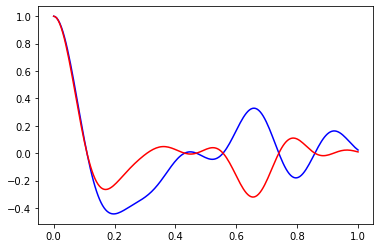

In [4]:
w1 = np.random.normal(0,20,10).reshape(-1,1)
w2 = np.random.normal(5,1,1).reshape(-1,1)
w3 = np.vstack((w1,w2))

X_plot = np.linspace(0,1,200)[:,None]
f_c=f_low(X_plot,w1)
f_e=f_high(X_plot,w3)

plt.plot(X_plot,f_c,'b-')
plt.plot(X_plot,f_e,'r-')
plt.show()

In [5]:
num_cheap = 30
num_expensive = 10

X1 = np.linspace(0,1,num_cheap)[:,None]
X2 = np.linspace(0,1,num_expensive)[:,None]

In [6]:
noise_level = 0.001

Yc = f_high(X1,w1)+ noise_level * np.random.normal(0,1,num_cheap)[:,None]
Ye = f_high(X2,w3) + 0.001 * np.random.normal(0,1,num_expensive)[:,None]

Optimization restart 1/10, f = 2.5695875432846655
Optimization restart 2/10, f = 2.569596983062013
Optimization restart 3/10, f = 2.569593470083003
Optimization restart 4/10, f = -27.269612543516153
Optimization restart 5/10, f = 2.5695949417389254
Optimization restart 6/10, f = 2.5695887083685047
Optimization restart 7/10, f = 2.56958753849735
Optimization restart 8/10, f = 2.569597057447872
Optimization restart 9/10, f = -27.269612543593176
Optimization restart 10/10, f = 2.5695875429788657


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a1e211518>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a1e211cf8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a1e211668>]}

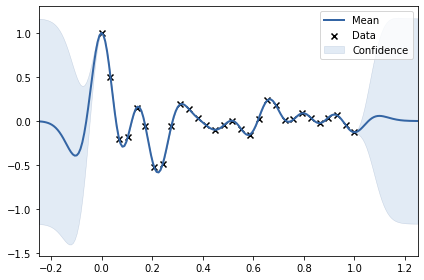

In [7]:
m1 = GPy.models.GPRegression(X1, Yc)
m1.optimize_restarts(num_restarts = 10)
m1.plot()

In [8]:
mu, v = m1.predict(X2, full_cov = True)

In [9]:
deepKern = MFRBF(input_dim=1, variance = 0.8, lengthscale = 0.2, mu = mu, v=v)
K1 = deepKern.K(X2)

In [10]:
kRBF = GPy.kern.RBF(input_dim = 1)

In [11]:
effKern = kRBF * deepKern

In [12]:
m2 = GPy.models.GPRegression(X2, Ye, effKern)

In [13]:
m2.optimize()
#m2.optimize(messages=True)
#m2.optimize_restarts(num_restarts = 5)

In [14]:
print(m2)


Name : GP regression
Objective : 8.76820642373396
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  mul.rbf.variance         |   0.8539042102115995  |      +ve      |        
  mul.rbf.lengthscale      |   1.0256047876575731  |      +ve      |        
  mul.MFRBF.variance       |  0.32123421887453174  |               |        
  mul.MFRBF.lengtscale     |   0.7298069928372648  |               |        
  Gaussian_noise.variance  |   0.6376258414217955  |      +ve      |        


In [16]:
print(m2.kern.rbf.variance[0])

0.8539042102115995


In [17]:
s1=m2.kern.rbf.variance[0]
l1=m2.kern.rbf.lengthscale[0]
s2=m2.kern.MFRBF.variance[0]
l2=m2.kern.MFRBF.lengthscale[0]

X_test = np.linspace(0,1,99)[:,None]
Y_test=[]
Y_test_up=[]
Y_test_down=[]

def predict_eff(CovMtx, Y):
    K_ee = CovMtx[1:,1:]
    K_e = CovMtx[0,1:]
    K_inv = np.linalg.inv(K_ee+0.0001*np.eye(K_ee.shape[0]))
    pred_mu = np.matmul(np.matmul(K_e, K_inv), Y)
    pred_v = CovMtx[0,0] - np.matmul(np.matmul(K_e, K_inv), np.matrix.transpose(K_e))
    return pred_mu, np.sqrt(pred_v)



for xx in X_test:
    Xnew = np.vstack((xx,X2))
    mu1, v1 = m1.predict(Xnew, full_cov = True)
    kernMF = MFRBF(input_dim=1,variance = s2, lengthscale = l2, mu = mu1, v=v1)
    kernRBF = GPy.kern.RBF(input_dim = 1, variance = s1, lengthscale = l1)
    M1 = kernMF.K(Xnew)
    M2 = kernRBF.K(Xnew)
    GG = np.multiply(M1, M2)
    
    pred_mu, pred_v = predict_eff(GG, Ye)
    
    Y_test.append(pred_mu)
    Y_test_up.append(pred_mu+1.96*pred_v)
    Y_test_down.append(pred_mu-1.96*pred_v)
    
    

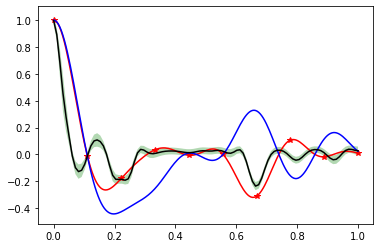

In [18]:
plt.plot(X2,Ye,'r*')
plt.plot(X_plot,f_e,'r-')
plt.plot(X_plot,f_c,'b-')
plt.plot(X_test,Y_test,'k-')
plt.fill_between(np.array(X_test).flatten(),np.array(Y_test_up).flatten(),np.array(Y_test_down).flatten(),facecolor='g',alpha=0.3)
plt.show()

Optimization restart 1/10, f = 3.3426188427744083
Optimization restart 2/10, f = 3.3426464582114335
Optimization restart 3/10, f = 3.342610272054987
Optimization restart 4/10, f = 3.3426098652061276
Optimization restart 5/10, f = 3.342611018113982
Optimization restart 6/10, f = 3.3426099520666597
Optimization restart 7/10, f = 3.342609853826696
Optimization restart 8/10, f = 3.3426098535528057
Optimization restart 9/10, f = 3.3426098504263635
Optimization restart 10/10, f = 3.3426099071724016


{'dataplot': [<matplotlib.collections.PathCollection at 0x116a4b390>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x116a4b2e8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x116a4ba90>]}

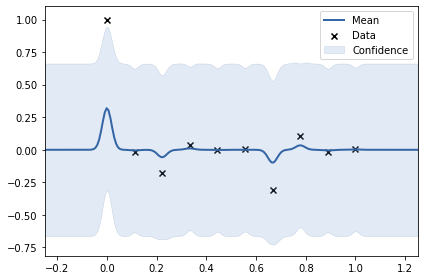

In [19]:
m3 = GPy.models.GPRegression(X2, Ye)
m3.optimize_restarts(num_restarts = 10)
m3.plot()

In [20]:
def fh_currin(x):
    x1 = x[:,0]
    x2 = x[:,1]
    tmp1 = 1-np.exp(-0.5/x2)
    tmp2 = 2300*x1**3+1900*x1**2+2092*x1+60
    tmp3 = 100*x1**3+500*x1**2+4*x1+20
    return tmp1*tmp2/tmp3

#xx_test=np.array([[0.1,0,1] [0.5,0.4]]).reshape(-1,2)
xx_test = np.random.random((10,2))
print(xx_test)
print(fh_currin(xx_test))
    

[[0.18661674 0.83356481]
 [0.32181374 0.53724293]
 [0.52030426 0.65446088]
 [0.06464271 0.48825386]
 [0.30603172 0.45731812]
 [0.34217942 0.14807178]
 [0.29681394 0.53305576]
 [0.1516718  0.63443878]
 [0.57031244 0.91376938]
 [0.2517195  0.84627187]]
[ 6.17807521  7.98077755  6.18767264  5.8370722   8.85140276 12.55031727
  8.14836867  7.20772397  4.75925872  6.11191542]


In [21]:
xx1 = xx_test[0].reshape(1,2)

print(xx1)
print(fh_currin(xx1))

[[0.18661674 0.83356481]]
[6.17807521]


In [22]:
xx_test1 = xx_test + np.array([0.05,0.05])
print(fh_currin(xx_test1))

[ 5.94805345  7.29577019  5.73971845  7.3070524   8.06629363 11.54363209
  7.45804176  7.14022503  4.47204864  5.70745935]


In [23]:
xx_test2 = xx_test + np.array([0.05,-0.05])
print(xx_test2)


[[0.23661674 0.78356481]
 [0.37181374 0.48724293]
 [0.57030426 0.60446088]
 [0.11464271 0.43825386]
 [0.35603172 0.40731812]
 [0.39217942 0.09807178]
 [0.34681394 0.48305576]
 [0.2016718  0.58443878]
 [0.62031244 0.86376938]
 [0.3017195  0.79627187]]


In [24]:
xx_test2[:,1] = np.maximum(0,xx_test2[:,1])

In [25]:
print(xx_test2)

[[0.23661674 0.78356481]
 [0.37181374 0.48724293]
 [0.57030426 0.60446088]
 [0.11464271 0.43825386]
 [0.35603172 0.40731812]
 [0.39217942 0.09807178]
 [0.34681394 0.48305576]
 [0.2016718  0.58443878]
 [0.62031244 0.86376938]
 [0.3017195  0.79627187]]


In [26]:
def fl_currin(x):
    tmp1 = fh_currin(x+np.array([0.05,0.05]))
    tmp2 = fh_currin(x+np.array([-0.05,0.05]))
    
    xp = x + np.array([0.05,-0.05])
    xp[:,1] = np.maximum(0,xp[:,1])
    
    xm = x + np.array([-0.05,-0.05])
    xm[:,1] = np.maximum(0,xm[:,1])
    
    tmp3 = fh_currin(xp)
    tmp4 = fh_currin(xm)
    
    return (tmp1+tmp2+tmp3+tmp4)/4.

y_c = fl_currin(xx_test)
print(fl_currin(xx_test))

[ 6.01314969  7.98945981  6.2156951   5.33226303  8.85162461 12.42779818
  8.14023046  6.90214348  4.77655896  6.0613091 ]


In [27]:
X_currin_cheap = np.random.random((12,2))
y_currin_cheap = fl_currin(X_currin_cheap)
y_currin_cheap = np.array(y_currin_cheap).reshape(-1,1)

X_currin_expensive = np.random.random((5,2))
y_currin_expensive = fh_currin(X_currin_expensive)
y_currin_expensive = np.array(y_currin_expensive).reshape(-1,1)

In [28]:
y_currin_cheap.shape

(12, 1)

In [29]:
y_currin_expensive.shape

(5, 1)

In [30]:
m4 = GPy.models.GPRegression(X_currin_cheap, y_currin_cheap)
m4.optimize()
#m4.optimize_restarts(num_restarts = 10)

In [31]:
print(m4)


Name : GP regression
Objective : 28.22652550367504
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    39.96358084105113  |      +ve      |        
  rbf.lengthscale          |  0.49007475594554684  |      +ve      |        
  Gaussian_noise.variance  |     1.17983507393928  |      +ve      |        


 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a2953b0b8>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1a2952bf98>]}

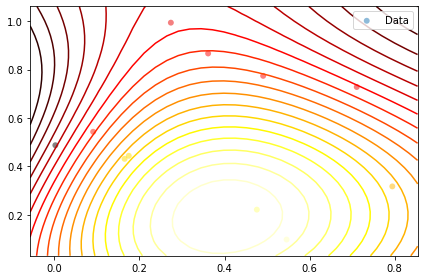

In [32]:
m4.plot()

In [33]:
mu_currin, v_currin = m4.predict(X_currin_expensive, full_cov = True)

In [34]:
kern_currin = MFRBF(input_dim=X_currin_expensive.shape[1], variance = 10, lengthscale = 1, mu = mu_currin, v=v_currin)
#k_currin_1 = deepKern.K(X_currin_expensive)

k_currin_rbf = GPy.kern.RBF(input_dim = X_currin_expensive.shape[1])

k_currin = kern_currin * k_currin_rbf

m_currin = GPy.models.GPRegression(X_currin_expensive, y_currin_expensive, k_currin)



In [35]:
m_currin.optimize()
#m2.optimize(messages=True)

#m_currin.optimize_restarts(num_restarts = 5)

In [36]:
print(m_currin)


Name : GP regression
Objective : 9.127515654760078
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  mul.MFRBF.variance       |     10.832670912759623  |               |        
  mul.MFRBF.lengtscale     |     21.681625939369994  |               |        
  mul.rbf.variance         |      4.910663874552978  |      +ve      |        
  mul.rbf.lengthscale      |      8.038928062081313  |      +ve      |        
  Gaussian_noise.variance  |  3.364052314916657e-06  |      +ve      |        


In [37]:
X_test = np.random.random((12,2)) 
y_test = fh_currin(X_test)
y_test = np.array(y_test).reshape(-1,1)


xx = X_test[0].reshape(1,2)

print(X_currin_expensive)
print(np.vstack((xx,X_currin_expensive)))
#print(X_test)

#print(y_test)



[[0.82452313 0.7900321 ]
 [0.70732467 0.82594962]
 [0.48807623 0.39910459]
 [0.99199301 0.9104917 ]
 [0.03886821 0.44104598]]
[[0.52842793 0.19975584]
 [0.82452313 0.7900321 ]
 [0.70732467 0.82594962]
 [0.48807623 0.39910459]
 [0.99199301 0.9104917 ]
 [0.03886821 0.44104598]]


In [38]:
s1=m_currin.kern.rbf.variance[0]
l1=m_currin.kern.rbf.lengthscale[0]
s2=m_currin.kern.MFRBF.variance[0]
l2=m_currin.kern.MFRBF.lengthscale[0]


Y_test=[]
Y_test_up=[]
Y_test_down=[]

for i in range(X_test.shape[0]):
    xx = X_test[i].reshape(1,2)
    Xnew = np.vstack((xx,X_currin_expensive))
    mu1, v1 = m4.predict(Xnew, full_cov = True)
    kernMF = MFRBF(input_dim=2,variance = s2, lengthscale = l2, mu = mu1, v=v1)
    kernRBF = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)
    M1 = kernMF.K(Xnew)
    M2 = kernRBF.K(Xnew)
    GG = np.multiply(M1, M2)
    
    pred_mu, pred_v = predict_eff(GG, y_currin_expensive)
    
    Y_test.append(pred_mu)
    Y_test_up.append(pred_mu+1.96*pred_v)
    Y_test_down.append(pred_mu-1.96*pred_v)
    

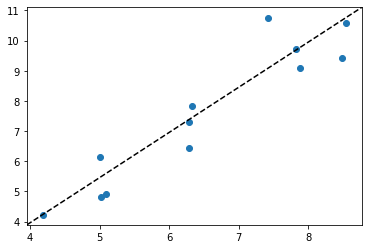

In [39]:
plt.scatter(Y_test,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.show()

In [40]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def compute_nll(y, mf, vf):
    y = y.reshape((y.shape[0],))
    ll = -0.5 * np.log(2 * np.pi * vf) - 0.5 * (y - mf)**2 / vf
    nll = -ll
    return np.mean(nll)

In [41]:
print(rmse(Y_test,y_test))

1.4710305446811283


In [42]:
print(compute_nll(y_test,Y_test,np.array(Y_test_up)-np.array(Y_test)))

4.615223434396536
